# Определение стоимости автомобилей

## Введение

Целью данного проекта является построить модель машинного обучения для определения рыночной стоимости автомобиля. Датасет представляет собой исторические данные: технические характеристики, комплектации и цены автомобилей. Целевыми характеристиками модели являются:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание признаков датасета:**

- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- NotRepaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.

**Целевой признак:**

- Price — цена (евро).

## План проекта

1. [Загрузим, предобработаем и подготовим данные.](#id_1)

2. [Обучим модели.](#id_2)

3. [Проанализируем обученные модели.](#id_3)

4. [Напишем общий вывод.](#id_4)

При построении моделей будем использовать:

1. Гребневая регрессия из библиотеки `sklearn` (*Ridge regression*);

2. Случайный лес из библиотеки `sklearn`;

3. Градиентный бустинг из библиотек `LightGBM` и `CatBoost`.

Качество предсказаний моделей будем оценивать по метрике *RMSE* - *Root Mean Square Error*, а время обучения и скорость предсказания будем измерть с помощью команды `%%time`. Так как время работы алгоритма будет измерятся не процессорным временем, следует отметить, что проект выполнялся на компютере с процессором *Ryzen 7 5800X*.

## Используемые библиотеки

В данном проекте используются следующие библиотеки:

- `pandas`;
- `numpy`;
- `matplotlib`;
- `seaborn`;
- `missingno`;
- `category_encoders`;
- `sklearn`;
- `CatBoost`;
- `lightgbm`;

##  Загрузка, предобработка и подготовка данных <a id='id_1'></a>

### Загрузка, первый взгляд на данные и вявления проблем для предобработки

Установим библиотеки:

In [1]:
!pip install seaborn -U
!pip install missingno -U
!pip install sklearn -U
!pip install category_encoders
!pip install lightgbm

Импортируем необходимые для работы библиотеки:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
!pip install lightgbm
import lightgbm as lgb

Запишем датасет в `df`, указав параметр `parse_dates` с признаки содержащими дату и время (DateCrawled, DateCreated, LastSeen) для изменения их типа данных в формат *datetime* на этапе записи датафрейма.

In [3]:
df = pd.read_csv(r'C:\Users\Wunderwaffe\Downloads\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Посмотрим первые пять объектов датафрейма:

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


И основную информацию о датафрейме методом *.info()*:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Проверим наличие дубликатов:

In [6]:
df.duplicated().sum()

4

Обозначим выявленные проблемы для предобработки данных:

1. Названия признаков следует привести в унифицированный вид: все в нижнем регистре;

2. В датафрейме есть пропуски, нужно устранить их на этапе предобработки;

3. В датафрейме найдено 4 дубликата.

Теперь попробуем выявить аномалии в датафрейме. Среди признаков встречаются как количественные, так и категориальные признаки. Выделим группы признаков по спискам (признаки содеражщие дату запишем в отдельный список):

In [9]:
categorial = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']
dates = ['DateCrawled', 'DateCreated', 'LastSeen']

In [10]:
len(categorial) + len(numeric) + len(dates)

16

Посмотрим основные статистические характеристики признаков для выявления аномалий:

In [11]:
df[numeric].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В целевом признаке price есть нулевые значения - это явная аномалия, сюда же относится нулевая (и огромная - 20000 л.с.) мощность автомобиля. Автомобиль, зарегестрированный больше тысячи лет назад также выглядит неправдоподобно (тоже касается значения 9999 год регистрации). Похоже, что признак numberofpictures содержит лишь нули. Признак postalcode выглядит без аномалий: минимальное значение признака - 01067 находится в городе в Дрезден, а максимальный находится в городе Кёрнер.

Посмотрим на долю выявленных аномалий:

In [15]:
df[df['Price'] == 0]['Price'].count() / len(df)

0.030397692800442477

In [16]:
(df[df['Power'] == 0]['Power'].count() + df[df['Power'] == 20000]['Power'].count()) / len(df)

0.11351444398353129

In [17]:
(df[df['RegistrationYear'] == 1000]['RegistrationYear'].count() + \
            df[df['RegistrationYear'] > 2022]['RegistrationYear'].count()) / len(df)

0.0004007122519181983

Доля аномалий в признаках price и registrationyear невелика (менее 3.1%) - эти аномалии можно отбросить, а вот в признаке power доля нулевых значений составляет 11.35% - неплохо было бы как-то восстановить правдопободные значения мощности автомобилей, можно попробовать воспользоваться методом k ближайших соседей.

Проверим число уникальных значений в признаке numberofpictures:

In [18]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

Действительно, признак содержит лишь нули. Значит он не несет в себе никакой информации и от него следует избавится.

In [19]:
df[categorial].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


Встречается много уникальных значений в признаках: vehicletype, fueltype, brand, model. Особенно много в двух последних (40 и 250 уникальных значений). Если LightGBM и CatBoost имеют встроенные методы обработки категориальных признаков, то для использования гребнеевой регрессии и нейросети категориальные признаки необходимо будет закодировать, прежде чем подавать в модель. Например, если использовать технику *one-hot encoding* мы получим большое число признаков (303 только из этих категориальных признаков). Так как из них хочется получить как можно больше информации для модели гребнеевой регрессии и нейросети воспользуемся `CatBoostEncoder`.

In [20]:
df[dates].describe()

,DateCrawled,DateCreated,LastSeen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Признаки datecrawled и lastseen вряд-ли принесут полезной информации для модели, так как дипазон их изменения ограничен одним месяцем - от них следует избавится. Из признака datecreated можно получить год и месяц создания объявления и таким образом  вытащить из него какую-нибудь полезную информацию для моделей. 

Аномалий в категориальных признаках и признаках, содержащие дату не выявлено.

Подведем итоги:

1. Названия признаков следует привести в унифицированный вид: все в нижнем регистре;

2. В датафрейме есть пропуски, нужно устранить их на этапе предобработки;

3. В датафрейме найдено 4 дубликата;

4. Целевой признак price содержит аномальные значения (нулевая цена), их доля составляет 3.0% - от них можно избавится;

5. Признак registrationyear содержит аномальные значения (год регистрации 1000, 9999), их доля около 0.1% - от них можно избавится;

6. Признак power содержит аномальные значения (нулевая мощность), их доля составляет 11.35%. Так как доля аномалий довольно высока, попробуем восстановить значения с помощью метода k ближайших соседей;

7. Признак numberofpictures содержит в себе лишь нули и не несет в себе никакой полезной информации для моделей -  от него следует избавится;

8. Признаки datecrawled и lastseen вряд-ли принесут полезной информации для модели, так как дипазон их изменения ограничен одним месяцем - от них следует избавится;

9. Из признака datecreated можно получить год и месяц создания объявления и таким образом  вытащить из него какую-нибудь полезную информацию для моделей;

10. Тип данных категориальных признаков можно изменить на `category`, чтобы повысить скорость CatBoost с набором признаков без кодирования и масштабирования.

### Предобработка данных

Преступим к предобработке данных. Сначала приведем названия признаков в унифицированный вид:

In [21]:
df.columns = df.columns.str.lower()

Также изменим регистр в списках с признаками которые мы создали ранее: 

In [22]:
numeric = [item.lower() for item in numeric]
categorial = [item.lower() for item in categorial]
dates = [item.lower() for item in dates]

Удалим дубликаты:

In [23]:
df = df.drop_duplicates()

Проверим их отсутствие:

In [24]:
df.duplicated().sum()

0

Прежде чем занятся пропущенными значениями займемся некоторыми аномалиями. Ранее мы обговорили, что избавимся от аномальных значений в признаках price и registrationyear. Чтобы избежать мутации датафрейма изменения будем записывать в новый датафрейм (также будет удобно фиксировать долю потери данных после предобработки):

In [25]:
df_filtred = df.query('price > 0 & registrationyear > 1000 & registrationyear < 2022')

Убедимся, что аномалии исчезли:

In [26]:
df_filtred[numeric].describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,343476.000000,343476.000000,343476.000000,343476.000000,343476.000000,343476.0,343476.000000
mean,4555.657280,2003.142889,110.995036,128378.474770,5.779461,0.0,50685.449470
std,4514.944235,8.886742,187.931155,37461.282958,3.697471,0.0,25744.454259
min,1.000000,1001.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30449.000000
50%,2890.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Оказалось, что все не так просто и аномалий больше (цена в 1 евро и год регистрации 1001 также остаются аномальными). Посмотрим распределение значений в этих признаках более детально:

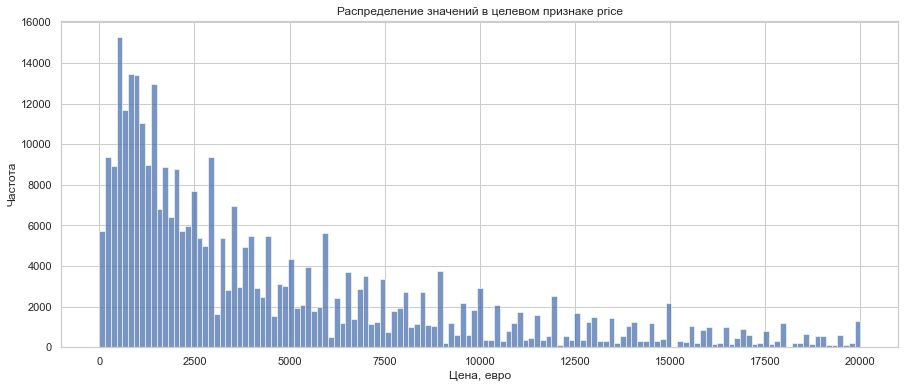

In [27]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,6))
sns.histplot(df_filtred['price'])
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.title('Распределение значений в целевом признаке price');

Похоже на логнормальное распределение, выглядит довольно естественно. После изучения объявлений продаж автомобилей в Европе, цена в 1 евро не кажется такой уж аномальной. В ссылке представлены объявления о продаже авто в Германии, где минимальная цена составляет 1 евро и имеется достаточно много автомобилей с низкой ценой (Источник: [сайт].URL:https://www.mobile.de/ru/категория/автомобиль/vhc:car,pgn:1,pgs:10,srt:price,sro:asc,prx:1000). 

Почему так дешево? Тут целый комплекс причин, но главная – потому что содержать автомобиль в странах Евросоюза довольно дорого, и хозяева устанавливают вот такие смешные цены, лишь бы избавиться от старого хлама, даже когда он таковым в действительности не является.

Чем старше авто, тем дороже страховка, тем больше налогов (например, за выхлопные выбросы и эмиссионный класс типа Euro-3/Euro-4), это и обязательный техосмотр, и ремонт, и вот такие дела. (Источник: [сайт].URL: https://tjournal.ru/travel/109543-v-evrope-slishkom-deshevye-poderzhannye-avtomobili-vot-nissan-i-bmw-za-900-evro)

По году регистрации поступим проще: отбросим все значения которые выходят за 3 интерквартильных расстояния (явные выбросы):

In [29]:
def drop_outliers(df, column):
    Q1 =  df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] > Q1-3*IQR ) & (df[column] < Q3+3*IQR)]

    return df

In [30]:
df_filtred = drop_outliers(df_filtred, 'registrationyear') 

Теперь построим распределение значений в признаке registrationyear:

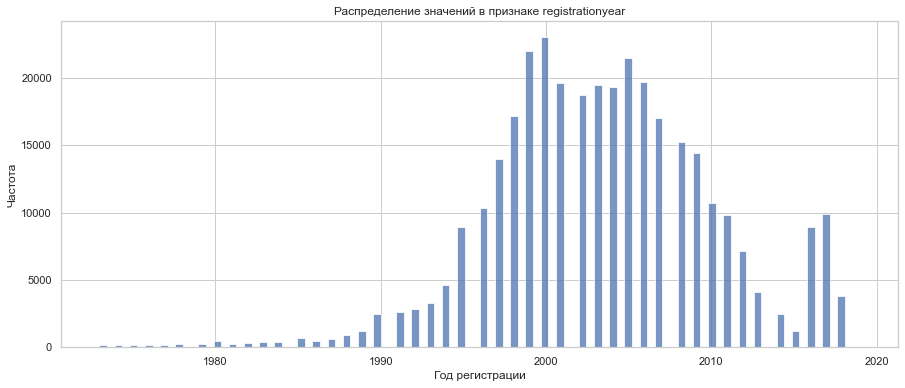

In [31]:
plt.figure(figsize=(15,6))
sns.histplot(df_filtred['registrationyear'], bins=100)
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.title('Распределение значений в признаке registrationyear');

Рассмотрим подробнее год регистрации с 1950 по 2019:

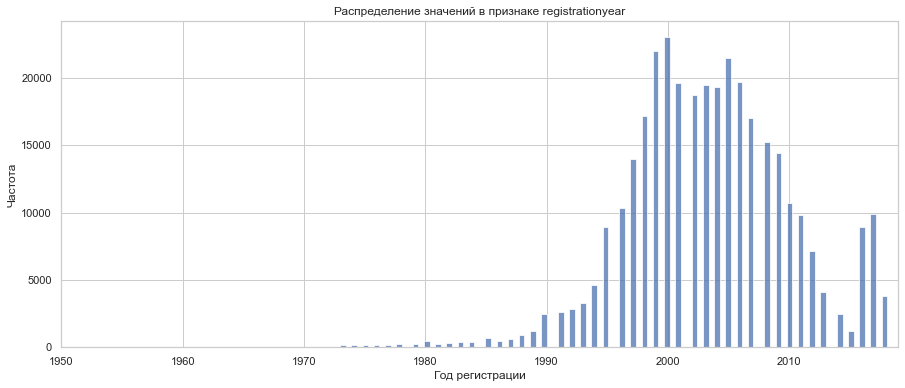

In [32]:
plt.figure(figsize=(15,6))
sns.histplot(df_filtred['registrationyear'], bins=100).set(xlim=(1950,2019))
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.title('Распределение значений в признаке registrationyear');

Явные выбросы удалены.

Теперь построим распределение значений в признаке power:

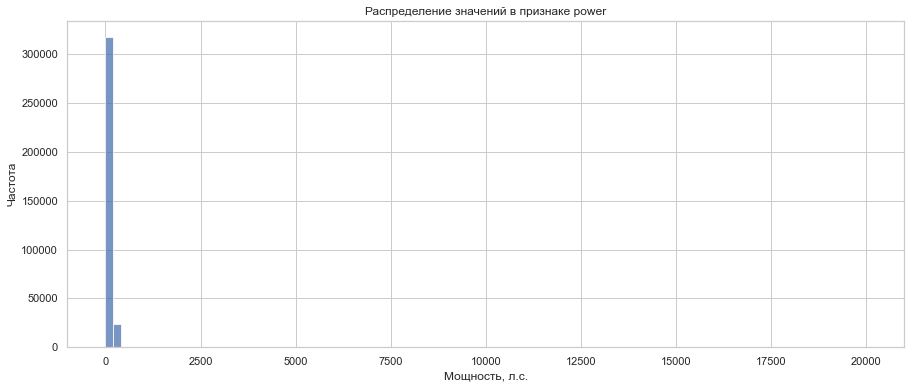

In [25]:
plt.figure(figsize=(15,6))
sns.histplot(df_filtred['power'], bins=100)
plt.xlabel('Мощность, л.с.')
plt.ylabel('Частота')
plt.title('Распределение значений в признаке power');

Посмотрим долю в данных, где мощность превышает 2000 л.с.

Отбросим явные выбросы и в этом признаке:

In [33]:
df_filtred = drop_outliers(df_filtred, 'power') 

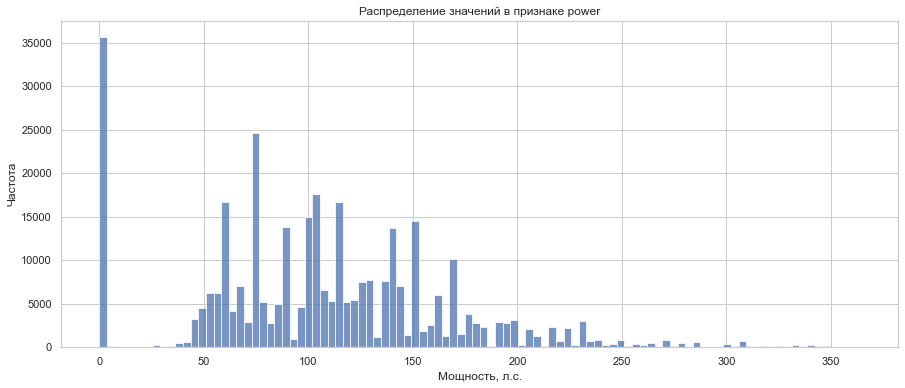

In [34]:
plt.figure(figsize=(15,6))
sns.histplot(df_filtred['power'], bins=100)
plt.xlabel('Мощность, л.с.')
plt.ylabel('Частота')
plt.title('Распределение значений в признаке power');

Попробуем использовать метод k ближайших соседей, чтобы заменить значения с аномальными нулевыми значениями в признаке power:

In [35]:
neigh = KNeighborsRegressor(n_neighbors=3)

In [36]:
%%time
neigh.fit(df_filtred[df_filtred['power'] != 0][numeric].drop('power', axis=1), 
          df_filtred[df_filtred['power'] != 0]['power'])

Wall time: 7.1 s


KNeighborsRegressor(n_neighbors=3)

In [37]:
df_filtred.loc[(df_filtred.power == 0), 'power'] = neigh.predict(
    df_filtred[df_filtred['power'] == 0][numeric].drop('power', axis=1))

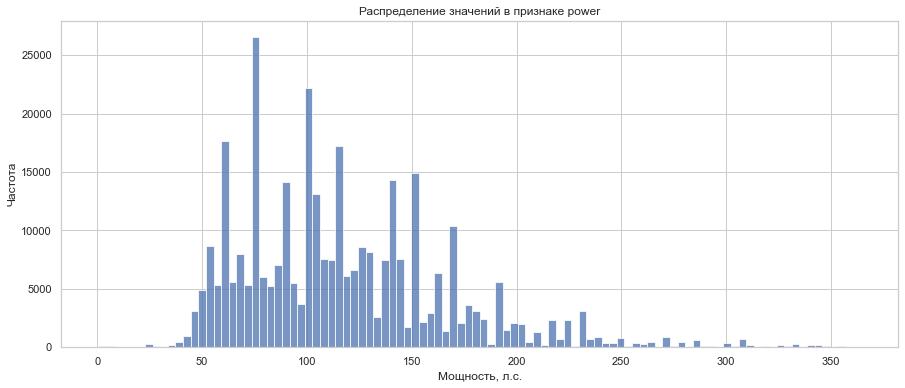

In [38]:
plt.figure(figsize=(15,6))
sns.histplot(df_filtred['power'], bins=100)
plt.xlabel('Мощность, л.с.')
plt.ylabel('Частота')
plt.title('Распределение значений в признаке power');

Перейдем к пропускам, посчитаем долю пропусков в каждом признаке датафрейма и отсортируем их в порядке убывания:

In [39]:
df_filtred.isna().mean().sort_values(ascending=False)

notrepaired          0.190557
vehicletype          0.097654
fueltype             0.084643
model                0.049535
gearbox              0.049259
datecrawled          0.000000
price                0.000000
registrationyear     0.000000
power                0.000000
kilometer            0.000000
registrationmonth    0.000000
brand                0.000000
datecreated          0.000000
numberofpictures     0.000000
postalcode           0.000000
lastseen             0.000000
dtype: float64

Имеем 19.1% пропусков в признаке notrepaired, 9.75% пропусков в признаке vehicletype, 8.47% пропусков в признаке fueltype и по 5.5% пропусков в признаках gearbox и model. Стоит отметить, что все признаки с пропусками являются категориальными.

Визуализируем пропуски с помощью библиотеки missingno:

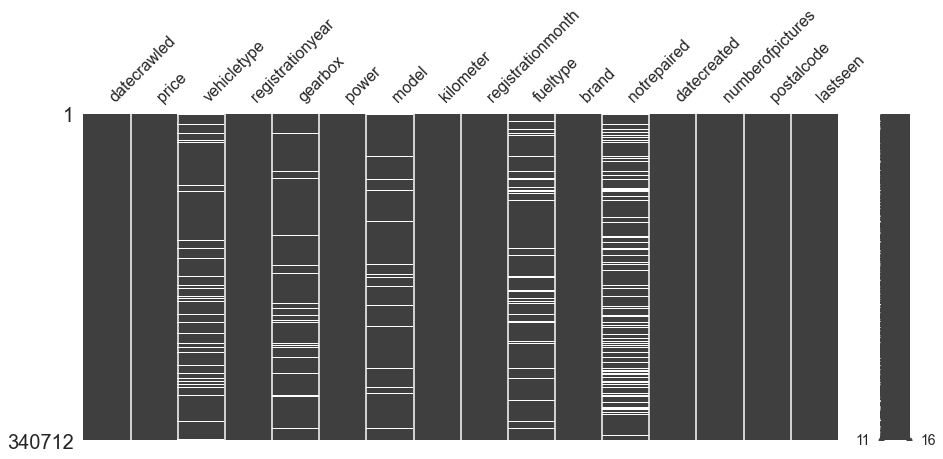

In [40]:
msno.matrix(df_filtred, figsize=(15,6));

Шаблон пропусков носит случайный характер, скорее всего эти параметры просто не были указаны. Так как все пропуски наблюдаются только в категориальных признаках - заполним их значением заглушкой.

In [41]:
df_filtred = df_filtred.fillna('no_data')

Убедимся в отсутствии пропусков:

In [42]:
df_filtred.isna().mean()

datecrawled          0.0
price                0.0
vehicletype          0.0
registrationyear     0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
registrationmonth    0.0
fueltype             0.0
brand                0.0
notrepaired          0.0
datecreated          0.0
numberofpictures     0.0
postalcode           0.0
lastseen             0.0
dtype: float64

Из признака datecreated получим два признака - год и месяц создания объявления:

In [43]:
df_filtred['year_created'] = pd.DatetimeIndex(df_filtred['datecreated']).year
df_filtred['month_created'] = pd.DatetimeIndex(df_filtred['datecreated']).month 

Избавимся от признаков datecrawled, numberofpictures, datecreated и lastseen:

In [44]:
df_filtred = df_filtred.drop(['datecrawled', 'numberofpictures', 'datecreated', 'lastseen'], axis=1)

Изменим тип данных категориальных переменных на `category`:

In [47]:
df_filtred[categorial] = df_filtred[categorial].astype('category')

Выведем первые пять объектов датафрейма и основную информацию о нем:

In [48]:
df_filtred.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode,year_created,month_created
0,480,no_data,1993,manual,109.0,golf,150000,0,petrol,volkswagen,no_data,70435,2016,3
1,18300,coupe,2011,manual,190.0,no_data,125000,5,gasoline,audi,yes,66954,2016,3
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no_data,90480,2016,3
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,91074,2016,3
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,60437,2016,3


In [49]:
df_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340712 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              340712 non-null  int64   
 1   vehicletype        340712 non-null  category
 2   registrationyear   340712 non-null  int64   
 3   gearbox            340712 non-null  category
 4   power              340712 non-null  float64 
 5   model              340712 non-null  category
 6   kilometer          340712 non-null  int64   
 7   registrationmonth  340712 non-null  int64   
 8   fueltype           340712 non-null  category
 9   brand              340712 non-null  category
 10  notrepaired        340712 non-null  category
 11  postalcode         340712 non-null  int64   
 12  year_created       340712 non-null  int64   
 13  month_created      340712 non-null  int64   
dtypes: category(6), float64(1), int64(7)
memory usage: 25.7 MB


Посчитаем долю данных, потерянную при предобработке:

In [50]:
len(df_filtred) / len(df)

0.9614719286611262

Предобработка завершена, отброшено менее 4% данных.

### Подготовка данных

Подготовим данные для моделей. Так как для гребнеевой регрессии и случайного леса необходимы закодированные категориальные признаки, а для градиентных бустингов LightGBM и CatBoost нет, мы разобьем исходные данные на два: закодированные и незакодированные. Также для градиентных бустингов мы сможем создать две дополнительные модели и сравнить их.

Для начала запишем признаки в датафрейм features, а целевой признак в датафрейм target:

In [51]:
features = df_filtred.drop('price', axis=1)
target = df_filtred['price']

При обучении моделей будем использовать 5-ти кратную кросс-валидацию, поэтому валидационный датасета нам не нужен. Разобьем исходный датасет на обучающую и отложенную выборку в соотношении 8:2.

Зафиксируем случайное состояние для воспроизводимости результатов:

In [52]:
SEED = 12345

In [53]:
features_train, features_test, target_train, target_test = train_test_split(
                                                                            features, 
                                                                            target, 
                                                                            test_size=.2, 
                                                                            random_state=SEED)

Проконтролируем разбиение:

In [54]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((272569, 13), (68143, 13), (272569,), (68143,))

Для кодировки категориальных признаков применим *CatBoostEncoder*:

In [55]:
cbe_encoder = ce.CatBoostEncoder()

In [56]:
features_train_cbe = cbe_encoder.fit_transform(features_train, target_train)

In [57]:
features_test_cbe = cbe_encoder.transform(features_test, target_test)

Посмотрим первые 5 объектов:

In [58]:
features_train_cbe.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode,year_created,month_created
322218,4513.553581,1997,4513.553581,193.0,4513.553581,150000,7,4513.553581,4513.553581,4513.553581,65187,2016,3
291559,4513.553581,2010,3456.276790,105.0,4513.553581,150000,1,4513.553581,4513.553581,3456.276790,90453,2016,3
36995,3456.276790,1994,4604.184527,90.0,4513.553581,150000,10,4513.553581,4513.553581,4604.184527,97070,2016,4
52530,5706.776790,2003,3652.888395,116.0,4513.553581,150000,9,3456.276790,4513.553581,3652.888395,71263,2016,3
259241,2570.517860,2006,3222.110716,226.0,4513.553581,125000,1,2803.851194,4513.553581,3222.110716,35104,2016,3


Признаки закодированы. Теперь, для гребнеевой регресии и нейросети их нужно масштабировать. Таким образом для градиентных бустингов мы сможем создать еще две дополнительные модели и сравнить их. Масштабировать признаки будем с помощью стандартизации:

In [59]:
scaler = StandardScaler()

In [60]:
features_train_cbe_scaled = scaler.fit_transform(features_train_cbe, target_train)
features_train_cbe_scaled = pd.DataFrame(data = features_train_cbe_scaled, columns = features_train_cbe.columns)

In [61]:
features_test_cbe_scaled = scaler.transform(features_test_cbe)
features_test_cbe_scaled = pd.DataFrame(data = features_test_cbe_scaled, columns = features_train_cbe.columns)

Признаки готовы к построению моделей.

## Обучение моделей <a id='id_2'></a>

### Гребнеевая регрессия

Зададим переделы изменения гиперпараметра альфа:

In [62]:
param_grid = {'alpha': np.arange(0.5, 10, 0.5)}

Инициализируем модель гребнеевой регрессии:

In [63]:
ridge = Ridge(random_state=SEED)

Оптимитизировать гиперпараметр будем с помощью поиска по сетке с 5-ти картной кросс-валидацией:

In [64]:
ridge_grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

In [66]:
%%time
ridge_grid.fit(features_train_cbe_scaled, target_train)

Wall time: 2.89 s


GridSearchCV(cv=5, estimator=Ridge(random_state=12345),
             param_grid={'alpha': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. , 8.5, 9. , 9.5])},
             scoring='neg_mean_squared_error')

Время обучения - 3.5 сек. посмотрим среднее значение *RMSE* на обучающей выборке:

In [67]:
np.abs(ridge_grid.best_score_) ** .5

2711.024699988088

Модель, в среднем, ошибается на 2711 евро на обучающей выборке, не очень хороший результат. Посмотрим метрику на тесте:

In [70]:
%%time
mean_squared_error(target_test, ridge_grid.predict(features_test_cbe_scaled)) ** .5

Wall time: 2 ms


2749.6899498450466

Немного лучше, но предсказания все равно имеют слишком большое отклонение. Скорость предсказания составила 2 мс.

### Случайный лес

Инициализиурем пустую модель случайного леса:

In [71]:
rfr = RandomForestRegressor(random_state=SEED)

Зададим сетку изменения гиперпараметров:

In [72]:
param_grid = {'n_estimators':[10,20,30],
              'max_features':['auto', 'sqrt', 'log2']}

Подберем модель с оптимальными гиперпараметрами на 5-ти кратной кросс-валидации:

In [73]:
rfr_grid = GridSearchCV(rfr, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

In [74]:
%%time
rfr_grid.fit(features_train_cbe, target_train)

Wall time: 1min 38s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 30]},
             scoring='neg_mean_squared_error')

Время обучения 122 сек, посмотрим значение *RMSE* на отложенной выборке:

In [75]:
%%time
mean_squared_error(target_test, rfr_grid.predict(features_test_cbe)) ** .5

Wall time: 497 ms


1710.817792932194

Модель случайного леса, в среднем, ошибается на 1000 евро меньше, чем гребнеевая регрессия. Попробуем добиться лучшего результата с использованием градиентного бустинга. Скорость предсказания составила 497 мс.

### CatBoost

Запишем тестовые пулы ко всем признакам:

In [76]:
test_pool = Pool(features_test, target_test, cat_features=categorial)
test_pool_cbe = Pool(features_test_cbe, target_test)
test_pool_cbe_scaled = Pool(features_test_cbe_scaled, target_test)

Подберем скорость обучения CatBoost с помощью поиска по сетке, зададим сетку изменения гиперпараметра:

In [77]:
param_grid = {'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}

Инициализируем пустую модель CatBoost:

In [78]:
cb_cv = CatBoostRegressor(random_state=SEED, 
                          eval_metric='RMSE', 
                          verbose=False)

Запустим поиск по сетке с 5-ти кратной кросс-валидацией:

In [79]:
%%time
grid_search_result = cb_cv.grid_search(param_grid, 
                                       Pool(features_train, target_train, cat_features=categorial), 
                                       plot=True,
                                       partition_random_seed=SEED,
                                       cv=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1569.866414
bestIteration = 999

0:	loss: 1569.8664141	best: 1569.8664141 (0)	total: 1m 21s	remaining: 8m 6s

bestTest = 1558.819254
bestIteration = 999

1:	loss: 1558.8192544	best: 1558.8192544 (1)	total: 2m 40s	remaining: 6m 41s

bestTest = 1548.661395
bestIteration = 993

2:	loss: 1548.6613950	best: 1548.6613950 (2)	total: 4m 6s	remaining: 5m 28s

bestTest = 1548.000787
bestIteration = 999

3:	loss: 1548.0007871	best: 1548.0007871 (3)	total: 5m 26s	remaining: 4m 5s

bestTest = 1542.056616
bestIteration = 993

4:	loss: 1542.0566161	best: 1542.0566161 (4)	total: 6m 42s	remaining: 2m 41s

bestTest = 1549.479762
bestIteration = 999

5:	loss: 1549.4797618	best: 1542.0566161 (4)	total: 7m 58s	remaining: 1m 19s

bestTest = 1541.770828
bestIteration = 999

6:	loss: 1541.7708279	best: 1541.7708279 (6)	total: 9m 13s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 1560.074507
bestIteration = 999

Training on fold [1/5]

bestTest = 1583.135398
bestItera

Время обучения составило 1082 сек, посмотрим *RMSE* на тестовой выборке:

In [84]:
%%time
mean_squared_error(target_test, cb_cv.predict(test_pool)) ** .5

Wall time: 68.1 ms


1543.5538744887917

Попробуем данные с кодированием. Инициализируем новую модель и запустим поиск по сетке:

In [85]:
cb_cv_cbe = CatBoostRegressor(random_state=SEED, eval_metric='RMSE', verbose=False)#, task_type="GPU")

In [86]:
%%time
grid_search_result = cb_cv_cbe.grid_search(param_grid, 
                                           Pool(features_train_cbe, target_train), 
                                           plot=True,
                                           partition_random_seed=SEED,
                                           cv=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1612.338701
bestIteration = 999

0:	loss: 1612.3387015	best: 1612.3387015 (0)	total: 10.1s	remaining: 1m

bestTest = 1604.743011
bestIteration = 995

1:	loss: 1604.7430112	best: 1604.7430112 (1)	total: 20.2s	remaining: 50.5s

bestTest = 1594.391536
bestIteration = 999

2:	loss: 1594.3915361	best: 1594.3915361 (2)	total: 30.4s	remaining: 40.5s

bestTest = 1596.760382
bestIteration = 990

3:	loss: 1596.7603818	best: 1594.3915361 (2)	total: 40.8s	remaining: 30.6s

bestTest = 1596.303208
bestIteration = 996

4:	loss: 1596.3032082	best: 1594.3915361 (2)	total: 50.9s	remaining: 20.4s

bestTest = 1603.555942
bestIteration = 924

5:	loss: 1603.5559424	best: 1594.3915361 (2)	total: 1m 1s	remaining: 10.2s

bestTest = 1599.902403
bestIteration = 999

6:	loss: 1599.9024032	best: 1594.3915361 (2)	total: 1m 11s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 1604.502817
bestIteration = 999

Training on fold [1/5]

bestTest = 1620.297253
bestIteration = 999



Время обучения составило 148 сек., получаем увеличение скорости обучения в 7.31 раз при кодировании признаков. Посмотрим значение метрики *RMSE*:

In [75]:
%%time
mean_squared_error(target_test, cb_cv_cbe.predict(test_pool_cbe)) ** .5

Wall time: 10.5 ms


1686.6237727264495

С кодированием признаков модель стала ошибаться на 134.78 евро больше, однако прирост скорости получился очень значительный.

Теперь попробуем данные с кодированием и масштабированием, инициализируем пустую модель и запустим поиск по сетке:

In [76]:
cb_cv_cbe_scaled = CatBoostRegressor(random_state=SEED, eval_metric='RMSE', verbose=False)#, task_type="GPU")

In [77]:
%%time
grid_search_result = cb_cv_cbe_scaled.grid_search(param_grid, 
                                                  Pool(features_train_cbe_scaled, target_train), 
                                                  plot=True,
                                                  partition_random_seed=SEED,
                                                  cv=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1628.567026
bestIteration = 998

0:	loss: 1628.5670265	best: 1628.5670265 (0)	total: 10.1s	remaining: 1m

bestTest = 1613.712095
bestIteration = 999

1:	loss: 1613.7120953	best: 1613.7120953 (1)	total: 20.1s	remaining: 50.2s

bestTest = 1610.716106
bestIteration = 991

2:	loss: 1610.7161058	best: 1610.7161058 (2)	total: 30s	remaining: 40s

bestTest = 1609.206755
bestIteration = 977

3:	loss: 1609.2067548	best: 1609.2067548 (3)	total: 40s	remaining: 30s

bestTest = 1609.540857
bestIteration = 996

4:	loss: 1609.5408571	best: 1609.2067548 (3)	total: 49.9s	remaining: 20s

bestTest = 1615.832576
bestIteration = 994

5:	loss: 1615.8325757	best: 1609.2067548 (3)	total: 59.9s	remaining: 9.98s

bestTest = 1621.31674
bestIteration = 891

6:	loss: 1621.3167403	best: 1609.2067548 (3)	total: 1m 9s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 1607.416242
bestIteration = 993

Training on fold [1/5]

bestTest = 1637.67309
bestIteration = 973

Training on f

Время обучения составило 149 сек., посмотрим значение метрики *RMSE*:

In [78]:
%%time
mean_squared_error(target_test, cb_cv_cbe_scaled.predict(test_pool_cbe_scaled)) ** .5

Wall time: 11 ms


1691.698870387341

Результат практически не изменился (увеличение *RMSE* на 5 евро).

Приведем результаты обучения моделей градиентного бустинга CatBoost в таблице:

|Особенности модели|Среднее *RMSE* на тесте, евро| Время обучения, сек.|  Скорость предсказания, мс |
|-----------------|------------------------------|---------------------|----------------------------|
|Признаки без кодировки и масштабирования| 1543.84 | 1082 | 72.1|
|Кодирование с помощью CatBoostEncoder| 1686.62 |148 | 13|
|CatBoostEncoder и масштабирование StandartScaler| 1691.70 | 149 | 11.5|

Лучшее значение *RMSE* (1551.84 евро) на тестовой выборке достигнуто с использованием чистых признаков (без кодирования и масштабирования), при времени обучения в 1082 сек. Кодирование признаков дает значительное ускорение (7.31 раз) на CPU (на GPU по неясной мне причине модели обучались дольше), однако при этом страдает качество метрики (модель ошибается, в среднем, на 134.78 евро больше при кодировании признаков, без масштабирования).

### LightGBM

Запишем словарь с параметрами:

In [79]:
param_lgb = {'objective':'regression',
              'metric': 'rmse',
              'verbose': -1,
              'seed': SEED}

Запустим LightGBM с 5-ти кратной кросс-валидацией на признаках без кодирования:

In [87]:
%%time
n_fold=5

folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

scores_RMSE = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(features_train, target_train)):
    x_train, x_valid = features_train.iloc[train_index], features_train.iloc[valid_index] 
    y_train, y_valid = target_train.iloc[train_index], target_train.iloc[valid_index]

    train_data = lgb.Dataset(x_train, 
                             y_train,
                             categorical_feature=categorial, 
                             free_raw_data=False)
    valid_data = lgb.Dataset(x_valid, 
                             y_valid,
                             categorical_feature=categorial, 
                             free_raw_data=False)
    
    lightgb = lgb.train(param_lgb,
                        train_set=train_data,
                        valid_sets=valid_data,
                        num_boost_round=1000,
                        verbose_eval = False)
    
    scores_RMSE.append(mean_squared_error(y_valid, lightgb.predict(x_valid)) ** .5)

print('RMSE mean: {:.3f}'.format(np.mean(scores_RMSE)))

RMSE mean: 1540.150
Wall time: 10.7 s


Время обучения 15.2 сек., средняя *RMSE* на кросс-валидации 1540.1 евро. Посмотрим *RMSE* на тесте:

In [88]:
%%time
mean_squared_error(target_test, lightgb.predict(features_test)) ** .5

Wall time: 309 ms


1517.6997759672372

На данный момент это самый быстрый и самый точный результат (обошел CatBoost с признаками без кодирования и масштабирования на 37.1 евро по качеству предсказания и оказался в 71 раз быстрее!).

Запустим LightGBM с 5-ти кратной кросс-валидацией на признаках с кодированием:

In [89]:
%%time
n_fold=5

folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

scores_RMSE = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(features_train_cbe, target_train)):
    x_train, x_valid = features_train_cbe.iloc[train_index], features_train_cbe.iloc[valid_index] 
    y_train, y_valid = target_train.iloc[train_index], target_train.iloc[valid_index]

    train_data = lgb.Dataset(x_train, 
                             y_train)
    valid_data = lgb.Dataset(x_valid, 
                             y_valid)
    
    lightgb_cbe = lgb.train(param_lgb,
                        train_set=train_data,
                        valid_sets=valid_data,
                        num_boost_round=1000,
                        verbose_eval = False)
    
    scores_RMSE.append(mean_squared_error(y_valid, lightgb_cbe.predict(x_valid)) ** .5)

print('RMSE mean: {:.3f}'.format(np.mean(scores_RMSE)))

RMSE mean: 1606.988
Wall time: 8.72 s


Время обучения 14.6 сек., средняя *RMSE* на кросс-валидации 1607.0 евро. Посмотрим *RMSE* на тесте:

In [90]:
%%time
mean_squared_error(target_test, lightgb_cbe.predict(features_test_cbe)) ** .5

Wall time: 254 ms


1689.346140204138

Результат немного хуже (*RMSE* больше на 3 евро), чем у CatBoost с кодированными признаками, однако он получится в 10 раз быстрее.

Запустим LightGBM с 5-ти кратной кросс-валидацией на признаках с кодированием и масштабированием:

In [91]:
%%time
n_fold=5

folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

scores_RMSE = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(features_train_cbe_scaled, target_train)):
    x_train, x_valid = features_train_cbe_scaled.iloc[train_index], features_train_cbe_scaled.iloc[valid_index] 
    y_train, y_valid = target_train.iloc[train_index], target_train.iloc[valid_index]

    train_data = lgb.Dataset(x_train, 
                             y_train)
    valid_data = lgb.Dataset(x_valid, 
                             y_valid)
    
    lightgb_cbe_scaled = lgb.train(param_lgb,
                        train_set=train_data,
                        valid_sets=valid_data,
                        num_boost_round=1000,
                        verbose_eval = False)
    
    scores_RMSE.append(mean_squared_error(y_valid, lightgb_cbe_scaled.predict(x_valid)) ** .5)

print('RMSE mean: {:.3f}'.format(np.mean(scores_RMSE)))

RMSE mean: 1604.631
Wall time: 8.78 s


Время обучения 14.6 сек., средняя *RMSE* на кросс-валидации 1607.0 евро. Посмотрим *RMSE* на тесте:

In [92]:
%%time
mean_squared_error(target_test, lightgb_cbe_scaled.predict(features_test_cbe_scaled)) ** .5

Wall time: 244 ms


1686.7026291656846

С масштабированием LightGBM немного вышел вперед (*RMSE* меньше на 5 евро) относительно CatBoost с кодарованными с масштабированными признаками. Время обучения также превосходит CatBoost в 10 раз.

Приведем результаты обучения моделей градиентного бустинга LightGBM в таблице:

|Особенности модели|Среднее *RMSE* на тесте, евро| Время обучения, сек.| Скорость предсказания, мс |
|-----------------|------------------------------|---------------------|---------------------------|
|Признаки без кодировки и масштабирования| 1517.69 | 15.2 | 387|
|Кодирование с помощью CatBoostEncoder| 1689.34 |14.6 | 346|
|CatBoostEncoder и масштабирование StandartScaler| 1686.70 | 14.7 |295|

Лучшее значение *RMSE* (1551.84 евро) на тестовой выборке достигнуто с использованием чистых признаков (без кодирования и масштабирования), при времени обучения в 1082 сек. Кодирование признаков дает значительное ускорение (7.31 раз) на CPU (на GPU по неясной мне причине модели обучались дольше), однако при этом страдает качество метрики (модель ошибается, в среднем, на 134.78 евро больше при кодировании признаков, без масштабирования).

## Анализ моделей <a id='id_3'></a>

Представим в таблице модели, их особенности и целевые показатели:

|Модель|Особенности модели|Среднее *RMSE* на тесте, евро| Время обучения, сек.|  Скорость предсказания, мс |
|------|-----------|------------------------------|---------------------|----------------------------|
|Ridge|CatBoostEncoder и масштабирование StandartScaler|2725.50| 3| 4|
|Random Forest|CatBoostEncoder и масштабирование StandartScaler| 1720.03| 122 | 635
||Признаки без кодировки и масштабирования| 1551.84 | 1082 | 72.1|
|CatBoost|Кодирование с помощью CatBoostEncoder| 1686.62 |148 | 13|
||CatBoostEncoder и масштабирование StandartScaler| 1691.70 | 149 | 11.5|
||Признаки без кодировки и масштабирования| 1517.69 | 15.2 | 387|
|LightGBM|Кодирование с помощью CatBoostEncoder| 1689.34 |14.6 | 346|
||CatBoostEncoder и масштабирование StandartScaler| 1686.70 | 14.7 |295|

Лучшей моделью по качеству предсказания оказалась модель градиентного бутсинга LightGBM с признаками без кодирования и масштабирования (значение *RMSE* 1517.69 евро), эта же модель имеет самое непродолжительное время обучения (гребнеевая регрессия не в счет) - 15.2. Самой близкой к ней оказалась модель CatBoost с признакми без кодирования и масштабирования, значение *RMSE* - 1551.84, однако время обучения CatBoost оказалось в 71 раз продолжительнее, нежели LightGBM. CatBoost в свою очередь может похватстаться высокой скоростю предсказания (в 5 раз быстрее).

Интересно, что при кодировании категориальных признаков время обучения моделей многократно снижается.

## Общий вывод <a id='id_4'></a>

В ходе разработки проекта данные были загружены, предобработаны и подготовлены для моделей. При предобработке даннных:

1. Названия признаков были приведены в унифицированный вид: все в нижнем регистре;

2. В датасете имелось большое число пропусков в категориальных признаках, шаблон пропусков носит случайный характер, скорее всего эти параметры просто не были указаны в объявлениях. Пропуски были заполнены значением-заглушкой `no_data`;

3. В датафрейме найдено и устранено 4 дубликата;

4. Целевой признак price содержал аномальные значения нулевой цены (доля 3.0%), такие значения были отброшены. Также в датасете встречаются аномально низкие значения цены, которые были проигнорированы, так как после изучения объявлений продаж автомобилей в Европе, цена в 1 евро не кажется такой уж аномальной. В ссылке представлены объявления о продаже авто в Германии, где минимальная цена составляет 1 евро и имеется достаточно много автомобилей с низкой ценой (Источник: [сайт].URL:https://www.mobile.de/ru/категория/автомобиль/vhc:car,pgn:1,pgs:10,srt:price,sro:asc,prx:1000).

5. Признак registrationyear содержал аномальные значения (год регистрации 1000, 9999), их доля около 0.1%, такие значения были отброшены;

6. Признак power содержал аномальные значения нулевой мощности атомобиля (доля аномалий 11.35%). Так как доля аномалий довольно высока, значения с нулями были заменены на предсказания с помощью метода k ближайших соседей;

7. Признак numberofpictures содержит в себе лишь нули и не несет в себе никакой полезной информации для моделей, он был отброшен; 

8. Признаки datecrawled и lastseen вряд-ли принесут полезной информации для модели, так как дипазон их изменения ограничен одним месяцем, они были отброшены; 

9. Из признака datecreated был получен год и месяц создания объявления и добавлен к остальным признакам при моделиролвании;

10. Тип данных категориальных признаков был изменен на category, чтобы повысить скорость CatBoost с набором признаков без кодирования и масштабирования.

После предобработки данных было отброшено менее 4% данных.

В проекте были построены модели:

1. Гребневая регрессия из библиотеки `sklearn` (*Ridge regression*), которая обучалась на закодированных признаках с помощью `CatBoostEncoder` и масштабированных с помощью стандартизации;

2. Случайный лес из библиотеки `sklearn`, который обучалась на закодированных признаках с помощью `CatBoostEncoder` и масштабированных с помощью стандартизации;

3. Градиентный бустинг из библиотек `LightGBM` и `CatBoost`, которые обучалась на исходных признаках, закодированных признаках с помощью `CatBoostEncoder`, а также на закодированных признаках с помощью `CatBoostEncoder` и масштабированных с помощью стандартизации.

Лучшей моделью по качеству предсказания оказалась модель градиентного бутсинга LightGBM с признаками без кодирования и масштабирования (значение RMSE 1517.69 евро), эта же модель имеет самое непродолжительное время обучения (гребнеевая регрессия не в счет) - 15.2. Самой близкой к ней оказалась модель CatBoost с признакми без кодирования и масштабирования, значение RMSE - 1551.84, однако время обучения CatBoost оказалось в 71 раз продолжительнее, нежели LightGBM. CatBoost в свою очередь может похватстаться высокой скоростю предсказания (в 5 раз быстрее).

Интересно, что при кодировании категориальных признаков время обучения моделей многократно снижается.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей